# Purpose

In Notebook 09.0x we took embeddings created by other models/steps & combined them:
```
new post = post + comments + subreddit description

new subreddit = new posts (weighted by post length)
```

In this notebook (nb 11), we'll focus on visualizing those embeddings.

# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import os
import logging

import fse
from fse.models import uSIF
import gensim
from gensim.models.fasttext import FastText, load_facebook_vectors
import joblib

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import umap

from subclu.data.fasttext_utils import (
    download_ft_pretrained_model,
    get_df_for_most_similar,
    get_project_subfolder,
)
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric,
    create_col_with_sparse_names,
    hide_aa_text_in_plotly_legend,
    reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language,
    get_language_by_sub_wide,
    get_language_by_sub_long,
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl,
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


print_lib_versions([fse, gensim, joblib, np, pd, plotly, umap])

python		v 3.7.10
===
fse		v: 0.1.15
gensim		v: 3.8.3
joblib		v: 1.0.1
numpy		v: 1.18.5
pandas		v: 1.2.4
plotly		v: 4.14.3
umap		v: 0.5.1


In [3]:
# plotting

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Provenance of data

The jobs used to create these embeddings came from these jobs:
- Subreddit descriptions: `84dd5a3878534f72b6442bcc0e4c8b95`
- Comments & posts: `3bf280ee76fc4595afc5e8cbaaf79a7d`

They were merged in notebook: `djb_09.00....ipynb`

Let's create a new uuid for this model?

In [ ]:
path_this_ft_model = get_project_subfolder(
    f"data/models/fse/manual_merge_2021-06-07_17"
)
path_this_ft_model

In [5]:
# list(f_.name for f_ in path_this_ft_model.glob('*.parquet'))

In [6]:
bucket_upload_dir = f'gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17'

In [7]:
# !gsutil ls -r $bucket_upload_dir

In [8]:
df_dist_full = pd.read_parquet(
    f'gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17/'
    f'df_distance_pair_meta_full-20210611-27722_by_11.parquet'
).reset_index()

df_dist_full = df_dist_full[
    reorder_array(
        list(df_dist_full.drop(['subreddit_id_a', 'subreddit_id_b'], axis=1).columns),
        df_dist_full.columns
    )
]
df_dist_full.shape

(27722, 11)

# Load compressed vectors

In [9]:
%%time

df_v_posts_merged_tsne2 = pd.read_parquet(
    path_this_ft_model / 
    'df_vectorized_posts_svd_tsne-init_pca-perplexity_30-rand_state_42-ids_index-111669_by_2.parquet'
)
df_v_posts_merged_tsne2.shape

CPU times: user 180 ms, sys: 42.9 ms, total: 223 ms
Wall time: 205 ms


(111669, 2)

In [10]:
%%time

df_v_subs_merged_tsne2 = pd.read_parquet(
    path_this_ft_model / 
    'df_vectorized_subs_svd_tsne-agg_to_subreddit-ids_index-167_by_2.parquet'
)
df_v_subs_merged_tsne2.shape

CPU times: user 5.53 ms, sys: 15.3 ms, total: 20.8 ms
Wall time: 15.8 ms


(167, 2)

# Load post & comment metadata

In [11]:
l_large_nsfw_subs = [
    'wixbros', 'katjakrasavicenudes',
    'deutschetributes', 'germannudes',
    'annitheduck', 'germanonlyfans',
    'loredana', 'nicoledobrikovof',
    'germansgonewild', 'elisaalinenudes',
    'marialoeffler', 'germanwomenandcouples',
    'germancelebritiesfap2', 'germancelebs',
    'nicoledobrikov', 'elisaaline1',
    'nicoledobrikov1', 'nicoledobrikovofs', 'germanpornstuff',
]

## Load & preprocess posts

In [188]:
%%time

# bucket_name = 
# folder_posts = 

l_cols_load = [
    # IDs
    'subreddit_name',
    'subreddit_id',
    'post_id',
#     'user_id',
#     'thing_type',
    
    # Meta
    'submit_date',
#     'removed',
    'upvotes',
#     'successful',
#     'app_name',
    'combined_topic_and_rating',
    'post_type',
    'post_nsfw',
    'geolocation_country_code',
    
    # Language & text content
    'post_url',
    'language',
    'probability',
    'weighted_language',
    'weighted_language_probability',
    'text_len',
    'text_word_count',
    'post_url_for_embeddings',
    'text'
]

col_manual_labels = 'manual_topic_and_rating'

df_posts = LoadPosts(
    bucket_name='i18n-subreddit-clustering',
    folder_path='posts/2021-05-19',
    columns=l_cols_load,
    col_new_manual_topic=col_manual_labels,
).read_and_apply_transformations()
df_posts.shape

05:34:54 | INFO | "Reading raw data..."
05:35:00 | INFO | "  Applying transformations..."


CPU times: user 659 ms, sys: 137 ms, total: 796 ms
Wall time: 5.68 s


(111669, 22)

In [189]:
# counts_describe(df_posts)

## Load & preprocess subs metadata

In [190]:
%%time

df_subs = LoadSubreddits(
    bucket_name='i18n-subreddit-clustering',
    folder_path='subreddits/2021-06-01',
    columns=None,
    col_new_manual_topic=col_manual_labels,
).read_and_apply_transformations()
df_subs.shape

05:35:00 | INFO | "Reading raw data..."
05:35:01 | INFO | "  Applying transformations..."


CPU times: user 25 ms, sys: 9.39 ms, total: 34.4 ms
Wall time: 331 ms


(196, 35)

In [191]:
df_subs = LoadSubreddits(
    bucket_name='i18n-subreddit-clustering',
    folder_path='subreddits/2021-06-01',
    columns=None,
    col_new_manual_topic=col_manual_labels,
).read_apply_transformations_and_merge_post_aggs(df_posts=df_posts)
df_subs.shape

05:35:01 | INFO | "  reading sub-level data & merging with aggregates..."
05:35:01 | INFO | "Reading raw data..."
05:35:01 | INFO | "  Applying transformations..."


(201, 43)

In [192]:
# counts_describe(df_subs)

### Create aggregates for language detected & post type

This gets now done within the method:
`.read_apply_transformations_and_merge_post_aggs(df_posts=df_posts)` 

In [193]:
print(df_posts['combined_topic_and_rating'].nunique())
# display(value_counts_and_pcts(df_posts['combined_topic_and_rating'], top_n=None))

print(df_subs['combined_topic_and_rating'].nunique())
# value_counts_and_pcts(df_subs['combined_topic_and_rating'], top_n=None)

21
21


In [194]:
print(df_posts[col_manual_labels].nunique())
# value_counts_and_pcts(df_posts[col_manual_labels], top_n=None)

print(df_subs[col_manual_labels].nunique())
# value_counts_and_pcts(df_subs[col_manual_labels], top_n=None)

15
15


### Aggregates from post to sub for plotting

- post_type (aggregated)
    - maybe images are more similar?
- post_nsfw (aggregated)
    - this might not be necessary given that I already have over-18 flag?
- text_len bins (aggregated)
    - maybe posts that are really short are close together?


In [195]:
# value_counts_and_pcts(df_posts['post_type'])

In [196]:
# value_counts_and_pcts(df_posts['post_type_agg2'])

In [197]:
# value_counts_and_pcts(df_posts['post_type_agg3'])

### Check distributions to get idea for cuts/bins

In [198]:
l_cols_pct_type = [
    'text_post_type_percent', 
    'image_post_type_percent',
    'link_post_type_percent',
    
    'German_posts_percent',
    'English_posts_percent',

]
df_plot_types = (
    df_subs.set_index(['subreddit_name'])
    [l_cols_pct_type]
    .stack()
    .to_frame()
    .reset_index()
    .rename(columns={0: 'percent', 'level_1': 'content_type'})
)

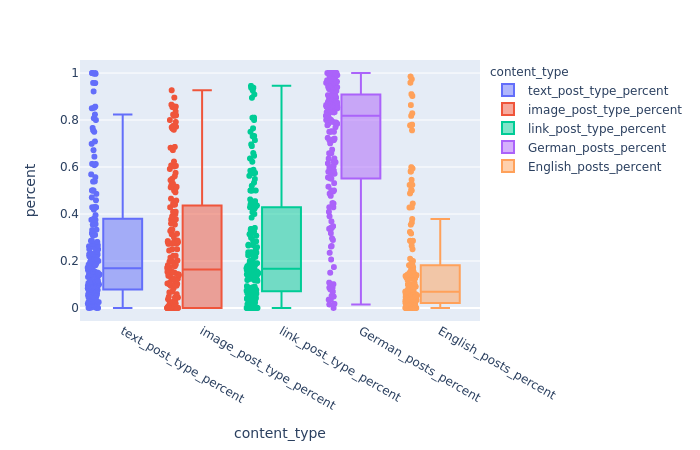

In [199]:
fig = px.box(
    df_plot_types,
    x='content_type',
    color='content_type',
    y="percent",
    points="all",
    # log_y=True,
)
# fig.show()
fig.show(renderer='png')

In [200]:
# df_subs[l_cols_pct_type].describe().T

# Append metadata to sub & post projections

In [201]:
%%time

df_v_subs_tsne_meta = (
    df_v_subs_merged_tsne2
    .reset_index()
    .drop(['subreddit_id', 'combined_topic_and_rating'], axis=1)
    .merge(
        df_subs,
        how='left',
        on=['subreddit_name']
    )
)
df_v_subs_tsne_meta.shape

CPU times: user 8.68 ms, sys: 86 µs, total: 8.77 ms
Wall time: 7.87 ms


(167, 45)

In [202]:
%%time

df_v_posts_tsne_meta = (
    df_v_posts_merged_tsne2
    .reset_index()
    .drop(['subreddit_name', 'subreddit_id'], axis=1)
    .merge(
        df_posts,
        how='left',
        on=['post_id']
    )
)
df_v_posts_tsne_meta.shape

CPU times: user 291 ms, sys: 3.91 ms, total: 295 ms
Wall time: 289 ms


(111669, 24)

## General things plot by (as color or size)

Might need to create some aggregates/roll-ups for some of these:

#### Post level
- subreddit_name
- new_topic_and_rating
- weighted_language_top
- post_type
    - maybe images are more similar? b/c they're short
- post_nsfw
- text_len bins
    - maybe posts that are really short are close together?
**size:**
- upvotes
- comments
- text_len

#### Subreddit level
- subreddit_name
- new_topic_and_rating
- weighted_language_top (aggregated)
- post_type (aggregated)
    - maybe images are more similar?
- post_nsfw (aggregated)
    - this might not be necessary given that I already have over-18 flag?
- text_len bins (aggregated)
    - maybe posts that are really short are close together?

**size:**
- views, l28
- post count
- comments count



# Plot as scatter


In [203]:
# meta for all posts
n_posts = len(df_v_posts_tsne_meta)
n_subs = df_v_posts_tsne_meta['subreddit_name'].nunique()
first_date = df_v_posts_tsne_meta['submit_date'].min()
last_date = df_v_posts_tsne_meta['submit_date'].max()


## Create new cols to show 2 lines of text for hovering info

In [204]:
n_chars_t1 = 50
n_chars_t2 = 60

df_v_posts_tsne_meta['text_1'] = df_v_posts_tsne_meta['text'].str[:n_chars_t1]
df_v_posts_tsne_meta['text_2'] = df_v_posts_tsne_meta['text'].str[n_chars_t1: n_chars_t1 + n_chars_t2]

### Create new col with only a few post names to make display more reasonable

In [205]:
df_v_posts_tsne_meta['subreddit_name_sparse'] = create_col_with_sparse_names(
    df_v_posts_tsne_meta,
    subreddits_to_ignore=None,
)
df_v_posts_tsne_meta['subreddit_name_sparse'].nunique()

168

### Create new col with labels for only: 50 SFW subs & top 10 NSFW subs

In [206]:
l_top_sfw_subs = list(
    df_subs[~df_subs['manual_topic_and_rating'].isin(['uncategorized', 'over18_nsfw'])]
    .sort_values(by=['users_l28'], ascending=False)
    ['subreddit_name']
    .head(40)
)
l_top_nsfw_subs = list(
    df_subs[df_subs['manual_topic_and_rating'].isin(['uncategorized', 'over18_nsfw'])]
    .sort_values(by=['users_l28'], ascending=False)
    ['subreddit_name']
    .head(10)
)
len(set(l_top_sfw_subs + l_top_nsfw_subs))

50

In [207]:
df_v_posts_tsne_meta['subreddit_name_sparse_top'] = np.where(
    df_v_posts_tsne_meta['subreddit_name'].isin(l_top_nsfw_subs + l_top_sfw_subs),
    df_v_posts_tsne_meta['subreddit_name_sparse'],
    ''
)
df_v_posts_tsne_meta['subreddit_name_sparse_top'].nunique()

49

### set default colors for categories

In [208]:
# sns.palplot([v for v in get_color_dict('dirl').values()])

In [209]:
# sns.palplot([v for v in get_color_dict('plotly').values()])

15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  []
15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  ['blue_purple', 'orange', 'mint', 'orange_light', 'yellow']


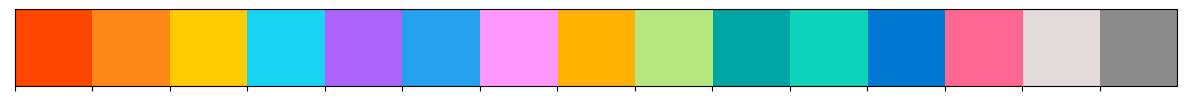

In [210]:
d_manual_label_colors = base_colors_for_manual_labels()
sns.palplot([v for v in d_manual_label_colors.values()])
check_colors_used(d_manual_label_colors, get_color_dict('dirl'))
check_colors_used(d_manual_label_colors, get_color_dict('plotly'))

In [211]:
# value_counts_and_pcts(df_subs[col_manual_labels])

### General config for post-level

Note that you need to use `fig.update_traces(hovertemplate=posts_hover_data)` to change the hover data.

There's no good way to remove the `Aa` lable next to the legends, except hacking the HTML's property: g.pointtext

In [212]:
from IPython.core.display import HTML
HTML("""
<style>
g.pointtext {display: none;}
</style>
""")
# hide_aa_text_in_plotly_legend()

In [213]:
posts_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
   "post text: %{customdata[2]}",
#    "  %{customdata[3]}"
])

l_custom_data_posts = ['subreddit_name', col_manual_labels, 'text_1',
                       # 'text_2'
                      ]

In [214]:
# df_v_posts_tsne_meta.head()

## Post level, colored by manual labels

In [239]:
df_post_label_count = value_counts_and_pcts(
    df_posts['manual_topic_and_rating'], 
    top_n=None, return_df=True, cumsum=False,
    count_type='posts', add_col_prefix=False,
)

style_df_numeric(
    df_post_label_count,
    l_bar_simple=['percent_of_posts'],
)

,posts_count,percent_of_posts
over18_nsfw,"63,543",56.90%
internet culture and memes,"16,731",14.98%
place/culture,"12,848",11.51%
uncategorized,"5,396",4.83%
podcasts and streamers,"3,555",3.18%
reddit institutions,"1,998",1.79%
"business, economics, and finance","1,895",1.70%
sports,"1,466",1.31%
food and drink,"1,003",0.90%
"culture, entertainment, music",862,0.77%


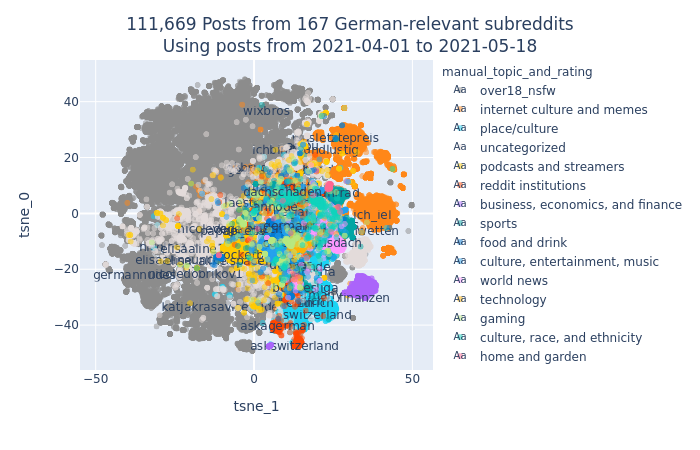

CPU times: user 1.69 s, sys: 12.1 ms, total: 1.71 s
Wall time: 4.69 s


In [242]:
%%time

fig = px.scatter(
    (
        df_v_posts_tsne_meta.sort_values(by=['subreddit_name_sparse_top'], ascending=True)
#         [['subreddit_name_sparse_top', 'tsne_0', 'tsne_1', col_manual_labels] + l_custom_data_posts]
    ),
    y='tsne_0', x='tsne_1',
    color=col_manual_labels,
    text='subreddit_name_sparse_top',
    custom_data=l_custom_data_posts,
    color_discrete_map=d_manual_label_colors,
    category_orders={col_manual_labels: list(df_post_label_count.index)},
    opacity=0.5,
)
# fig.update_traces(hovertemplate=posts_hover_data)
fig.update_layout(
    title_text=(
        f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
        f"<br>Using posts from {first_date} to {last_date}"
    ),
    title_x=0.5,
    width=1100,
    height=800,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

In [217]:
value_counts_and_pcts(
    df_posts[df_posts['manual_topic_and_rating'] == 'uncategorized'],
    ['manual_topic_and_rating', 'subreddit_name']
)

In [218]:
value_counts_and_pcts(df_subs['manual_topic_and_rating'])

,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,52,25.9%,25.9%
gaming,29,14.4%,40.3%
uncategorized,23,11.4%,51.7%
reddit institutions,21,10.4%,62.2%
food and drink,18,9.0%,71.1%
sports,15,7.5%,78.6%
internet culture and memes,12,6.0%,84.6%
"culture, entertainment, music",12,6.0%,90.5%
place/culture,8,4.0%,94.5%
podcasts and streamers,5,2.5%,97.0%


## Subreddit level

In [185]:
### fill nulls for sizing in l28

In [186]:
df_v_subs_tsne_meta['users_l28'] = (
    df_v_subs_tsne_meta['users_l28']
    .fillna(df_v_subs_tsne_meta['users_l28'].quantile(0.25))
)

In [270]:
# style_df_numeric(df_v_subs_tsne_meta['users_l28'].describe().to_frame())

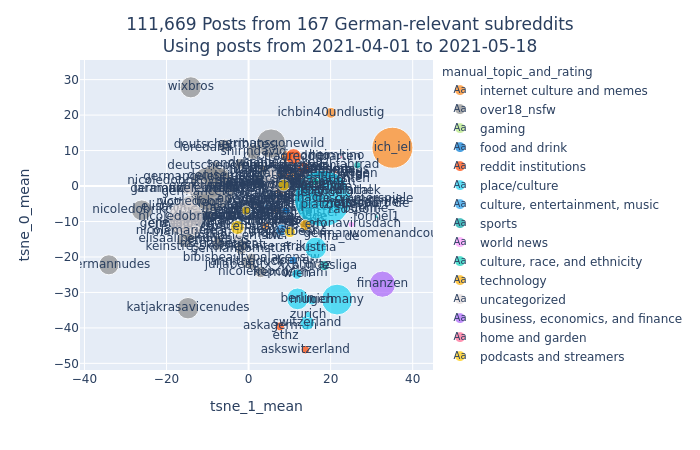

CPU times: user 91.8 ms, sys: 7.85 ms, total: 99.7 ms
Wall time: 320 ms


In [271]:
%%time

fig = px.scatter(
    df_v_subs_tsne_meta,
    y='tsne_0_mean', x='tsne_1_mean',
    color=col_manual_labels,
    text='subreddit_name',
#     custom_data=l_custom_data_posts,
    color_discrete_map=d_manual_label_colors,
    size='users_l28',
    size_max=40,
)
# fig.update_traces(hovertemplate=posts_hover_data, size_min=4)
fig.update_layout(
    title_text=(
        f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
        f"<br>Using posts from {first_date} to {last_date}"
    ),
    title_x=0.5,
    width=900,
    height=700,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

# Compare distances

In [334]:
# df_subs.drop(['subreddit_description', 'subreddit_name_title_and_clean_descriptions'], axis=1).head(10)

In [310]:
l_dist_display = [
    'cosine_distance',
    'subreddit_name_a',
    'subreddit_name_b',
    
#     'manual_topic_and_rating_a',
    'manual_topic_and_rating_b',
    
    'German_posts_percent_a',
    'German_posts_percent_b',

    'post_median_word_count_a',
    'post_median_word_count_b',
#     'subreddit_id_a',
#     'subreddit_id_b'
]

In [323]:
df_dist_full['cosine_distance'].describe()

count    27722.000000
mean         0.420410
std          0.204020
min         -0.206531
25%          0.288213
50%          0.426910
75%          0.565296
max          0.959810
Name: cosine_distance, dtype: float64

## Highlights

In [320]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'fifa_de'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.6306,fifa_de,battlefieldde,gaming,92.31%,77.78%,12,8
0.6171,fifa_de,fussball,sports,92.31%,84.25%,12,12
0.5778,fifa_de,footballmanagerde,gaming,92.31%,57.14%,12,9
0.5622,fifa_de,bundesliga,sports,92.31%,33.69%,12,14
0.5554,fifa_de,radsport,sports,92.31%,81.12%,12,11
0.5444,fifa_de,platzreife,sports,92.31%,84.55%,12,8
0.5403,fifa_de,xboxde,gaming,92.31%,90.91%,12,10
0.5232,fifa_de,rocketbeans,podcasts and streamers,92.31%,89.54%,12,23
0.5208,fifa_de,eurotruckde,gaming,92.31%,83.33%,12,10
0.5182,fifa_de,playsi,gaming,92.31%,85.71%,12,10


In [321]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'germany'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.9346,germany,berlin,place/culture,3.53%,17.41%,53,38
0.9200,germany,munich,place/culture,3.53%,15.00%,53,47
0.9065,germany,askagerman,reddit institutions,3.53%,3.60%,53,62
0.9041,germany,switzerland,place/culture,3.53%,8.64%,53,45
0.9029,germany,ethz,uncategorized,3.53%,1.74%,53,77
0.8995,germany,zurich,place/culture,3.53%,5.13%,53,36
0.8521,germany,askswitzerland,reddit institutions,3.53%,1.49%,53,90
0.8323,germany,wien,place/culture,3.53%,78.41%,53,21
0.8015,germany,bundesliga,sports,3.53%,33.69%,53,14
0.7995,germany,nicolekopchak,over18_nsfw,3.53%,0.00%,53,1


In [329]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'vegetarischde'  # vegetarischde, vegande
    ][l_dist_display].head(10),
    rename_cols_for_display=True,
    float_round=4,
    l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.9008,vegetarischde,kochen,food and drink,96.81%,88.74%,9,8
0.9004,vegetarischde,veganerezepte,food and drink,96.81%,80.00%,9,6
0.8567,vegetarischde,vegetarischkochen,food and drink,96.81%,72.09%,9,5
0.8520,vegetarischde,vegande,food and drink,96.81%,96.01%,9,16
0.8453,vegetarischde,gaumengraus,food and drink,96.81%,85.00%,9,7
0.8364,vegetarischde,asiatischkochen,food and drink,96.81%,78.38%,9,6
0.8357,vegetarischde,600euro,internet culture and memes,96.81%,88.10%,9,7
0.8326,vegetarischde,memebiss,food and drink,96.81%,89.06%,9,6
0.8237,vegetarischde,dachschaden,"culture, race, and ethnicity",96.81%,90.19%,9,11
0.8219,vegetarischde,backen,food and drink,96.81%,62.07%,9,4


In [374]:
# style_df_numeric(
#     df_dist_full[
#         df_dist_full['subreddit_name_a'] == 'katikarenina'
#     ][l_dist_display].head(10),
#     rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
# ).hide_index()

## low-lights / edge cases

In [315]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'de'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.9115,de,dachschaden,"culture, race, and ethnicity",96.90%,90.19%,13,11
0.9067,de,mauerstrassenwetten,internet culture and memes,96.90%,89.67%,13,8
0.9051,de,rbtv_cj,internet culture and memes,96.90%,87.23%,13,8
0.8966,de,600euro,internet culture and memes,96.90%,88.10%,13,7
0.8869,de,nachrichten,world news,96.90%,96.34%,13,10
0.8828,de,de_iama,reddit institutions,96.90%,100.00%,13,46
0.8820,de,laesterschwestern,podcasts and streamers,96.90%,90.58%,13,20
0.8729,de,geschichtsmaimais,internet culture and memes,96.90%,87.71%,13,6
0.8676,de,wasletztepreis,internet culture and memes,96.90%,92.37%,13,3
0.8465,de,coronavirusdach,world news,96.90%,94.84%,13,10


In [316]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'ich_iel'
    ][l_dist_display].head(10),
    rename_cols_for_display=True,
    float_round=4,
    l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.7651,ich_iel,okbrudimongo,internet culture and memes,99.07%,59.73%,2,4
0.6783,ich_iel,okoidawappler,uncategorized,99.07%,63.59%,2,5
0.6432,ich_iel,germansgonewild,over18_nsfw,99.07%,92.40%,2,9
0.6416,ich_iel,ichbin40undlustig,internet culture and memes,99.07%,94.33%,2,15
0.6225,ich_iel,shirindavid,over18_nsfw,99.07%,51.61%,2,3
0.6016,ich_iel,geschichtsmaimais,internet culture and memes,99.07%,87.71%,2,6
0.5963,ich_iel,loredana,uncategorized,99.07%,85.29%,2,8
0.5732,ich_iel,deutschetributes,over18_nsfw,99.07%,83.75%,2,8
0.5639,ich_iel,aeiou,internet culture and memes,99.07%,65.87%,2,5
0.5622,ich_iel,spube,"culture, entertainment, music",99.07%,60.00%,2,9


In [335]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'bundesliga'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.8015,bundesliga,germany,place/culture,33.69%,3.53%,14,53
0.7817,bundesliga,wien,place/culture,33.69%,78.41%,14,21
0.7713,bundesliga,munich,place/culture,33.69%,15.00%,14,47
0.7671,bundesliga,berlin,place/culture,33.69%,17.41%,14,38
0.7122,bundesliga,askagerman,reddit institutions,33.69%,3.60%,14,62
0.7075,bundesliga,switzerland,place/culture,33.69%,8.64%,14,45
0.7036,bundesliga,zurich,place/culture,33.69%,5.13%,14,36
0.6997,bundesliga,ethz,uncategorized,33.69%,1.74%,14,77
0.6816,bundesliga,austria,place/culture,33.69%,85.07%,14,10
0.6682,bundesliga,juliabeautx_xxx,over18_nsfw,33.69%,6.96%,14,9


In [371]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'nicolekopchak'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.8521,nicolekopchak,berlin,place/culture,0.00%,17.41%,1,38
0.8202,nicolekopchak,askagerman,reddit institutions,0.00%,3.60%,1,62
0.8188,nicolekopchak,munich,place/culture,0.00%,15.00%,1,47
0.8116,nicolekopchak,switzerland,place/culture,0.00%,8.64%,1,45
0.8089,nicolekopchak,zurich,place/culture,0.00%,5.13%,1,36
0.7995,nicolekopchak,germany,place/culture,0.00%,3.53%,1,53
0.7984,nicolekopchak,askswitzerland,reddit institutions,0.00%,1.49%,1,90
0.7841,nicolekopchak,ethz,uncategorized,0.00%,1.74%,1,77
0.7259,nicolekopchak,annitheduck,over18_nsfw,0.00%,8.63%,1,8
0.7241,nicolekopchak,wien,place/culture,0.00%,78.41%,1,21


In [345]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'bier'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.7101,bier,doener,food and drink,60.47%,55.56%,9,9
0.6886,bier,buenzli,internet culture and memes,60.47%,75.25%,9,6
0.6814,bier,austria,place/culture,60.47%,85.07%,9,10
0.6784,bier,wien,place/culture,60.47%,78.41%,9,21
0.6635,bier,germanrap,"culture, entertainment, music",60.47%,65.85%,9,7
0.6087,bier,bundesliga,sports,60.47%,33.69%,9,14
0.6085,bier,graz,uncategorized,60.47%,94.48%,9,26
0.6066,bier,vegande,food and drink,60.47%,96.01%,9,16
0.6029,bier,rocketbeans,podcasts and streamers,60.47%,89.54%,9,23
0.5831,bier,munich,place/culture,60.47%,15.00%,9,47


In [346]:
style_df_numeric(
    df_dist_full[
        df_dist_full['subreddit_name_a'] == 'doener'
    ][l_dist_display].head(10),
    rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
).hide_index()

cosine distance,subreddit name a,subreddit name b,manual topic and rating b,German posts percent a,German posts percent b,post median word count a,post median word count b
0.7227,doener,wien,place/culture,55.56%,78.41%,9,21
0.7101,doener,bier,food and drink,55.56%,60.47%,9,9
0.6798,doener,berlin,place/culture,55.56%,17.41%,9,38
0.6712,doener,munich,place/culture,55.56%,15.00%,9,47
0.6605,doener,germanpornstuff,over18_nsfw,55.56%,31.82%,9,6
0.6520,doener,germany,place/culture,55.56%,3.53%,9,53
0.6469,doener,zurich,place/culture,55.56%,5.13%,9,36
0.6292,doener,austria,place/culture,55.56%,85.07%,9,10
0.6258,doener,askagerman,reddit institutions,55.56%,3.60%,9,62
0.6211,doener,bundesliga,sports,55.56%,33.69%,9,14


In [372]:
# style_df_numeric(
#     df_dist_full[
#         df_dist_full['subreddit_name_b'] == 'germanwomenandcouples'
#     ][l_dist_display].head(10),
#     rename_cols_for_display=True, float_round=4, l_bar_simple=['German_posts_percent_b',]  # 'cosine_distance', 
# ).hide_index()

In [365]:
(
    df_dist_full[
        ((df_dist_full['subreddit_name_b'] == 'germanwomenandcouples') &  # nicolekopchak  germanwomenandcouples
         (df_dist_full['manual_topic_and_rating_a'] != 'over18_nsfw')
        )
    ]
    .sort_values(by=['cosine_distance'], ascending=False)
)

,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b,subreddit_id_a,subreddit_id_b
2332,0.852071,berlin,nicolekopchak,0.174053,0.0,place/culture,over18_nsfw,38.0,1.0,t5_2qt49,t5_lcxlv
1169,0.820169,askagerman,nicolekopchak,0.035990,0.0,reddit institutions,over18_nsfw,62.0,1.0,t5_2y3st,t5_lcxlv
19098,0.818814,munich,nicolekopchak,0.150000,0.0,place/culture,over18_nsfw,47.0,1.0,t5_2s6s2,t5_lcxlv
24741,0.811614,switzerland,nicolekopchak,0.086372,0.0,place/culture,over18_nsfw,45.0,1.0,t5_2qhp6,t5_lcxlv
27564,0.808913,zurich,nicolekopchak,0.051282,0.0,place/culture,over18_nsfw,36.5,1.0,t5_2s7k8,t5_lcxlv
...,...,...,...,...,...,...,...,...,...,...,...
10453,-0.082997,garten,nicolekopchak,0.975728,0.0,home and garden,over18_nsfw,10.0,1.0,t5_2unl9,t5_lcxlv
6467,-0.090389,duschgedanken,nicolekopchak,1.000000,0.0,reddit institutions,over18_nsfw,15.0,1.0,t5_3255n,t5_lcxlv
6966,-0.115216,einheitsgebot,nicolekopchak,0.958333,0.0,food and drink,over18_nsfw,6.5,1.0,t5_3oaw8,t5_lcxlv
13111,-0.117588,gutenachrichten,nicolekopchak,1.000000,0.0,reddit institutions,over18_nsfw,13.0,1.0,t5_4e6q9m,t5_lcxlv


In [340]:
df_subs['post_median_word_count'].describe()

count    167.000000
mean      17.404192
std       29.927570
min        1.000000
25%        6.000000
50%        8.000000
75%       12.500000
max      255.000000
Name: post_median_word_count, dtype: float64

In [ ]:
df_dist

In [355]:
# df_subs[df_subs['subreddit_name'].str.contains('german')]

In [344]:
df_subs[df_subs['post_median_word_count'] <=3].head(10)

,subreddit_id,subreddit_name,geo_country_code,pct_sv_country,rank_no,subreddit_info_ambassador,subreddit_topic_ambassador,combined_topic,combined_topic_and_rating,rating,rating_version,topic,topic_version,over_18,allow_top,video_whitelisted,subreddit_language,whitelist_status,subscribers,first_screenview_date,last_screenview_date,users_l7,users_l28,posts_l7,posts_l28,comments_l7,comments_l28,pt,subreddit_clean_description_word_count,subreddit_name_title_and_clean_descriptions_word_count,subreddit_title,subreddit_public_description,subreddit_description,subreddit_name_title_and_clean_descriptions,manual_topic_and_rating,German_posts_percent,English_posts_percent,other_language_posts_percent,image_post_type_percent,link_post_type_percent,other_post_type_percent,text_post_type_percent,post_median_word_count
3.0,t5_37k29,ich_iel,DE,0.669734,3.0,None,None,internet culture and memes,internet culture and memes,pg13,v2,Internet Culture and Memes,v3,None,t,None,de,all_ads,308654.0,2020-08-24,2021-05-30,292751.0,685311.0,1436.0,6769.0,20259.0,81748.0,2021-06-02,158.0,167.0,ich iel - selbsties der seele,selbsties der seele,"Alle Pfosten müssen den Titel ""ich_iel"" haben, der Unterstrich darf durch ein beliebiges Symbol oder Bildschriftzeichen ersetzt werden. Ihr dürft euch frei entfalten!\n\n___\n\n**Unsere Regeln:**\n\n1. Seid nett zueinander. Beleidigunge...","ich_iel. \nich iel - selbsties der seele. \nselbsties der seele. \nAlle Pfosten müssen den Titel ""ich iel"" haben, der Unterstrich darf durch ein beliebiges Symbol oder Bildschriftzeichen ersetzt werden. Ihr dürft euch frei entfalten!\n\...",internet culture and memes,0.990667,0.001414,0.007919,0.858032,0.072115,0.066082,0.003771,2.0
6.0,t5_3ntp6,wasletztepreis,DE,0.859844,12.0,None,None,funny/humor,funny/humor,pg,v2,Funny/Humor,v3,None,t,None,de,all_ads,135488.0,2020-08-24,2021-05-30,82660.0,201973.0,176.0,693.0,2239.0,8771.0,2021-06-02,261.0,268.0,Was letzte Preis?,Was letzte Preis?,##Regeln\n\n**[\(Hier geht's zur ausführlicheren Hausordnung\)](https://www.reddit.com/r/wasletztepreis/wiki/regeln)**\n\nPosts werden nicht auf einer Qualitätsbasis moderiert. Solange der Post On-Topic ist (also einen humoristischen Be...,wasletztepreis. \nWas letzte Preis?. \nWas letzte Preis. \n##Regeln\n\n**[\(Hier geht's zur ausführlicheren Hausordnung\)](wasletztepreis regeln)**\n\nPosts werden nicht auf einer Qualitätsbasis moderiert. Solange der Post On Topic ist...,internet culture and memes,0.923651,0.033195,0.043154,0.769295,0.084647,0.136100,0.009959,3.0
31.0,t5_htsbz,shirindavid,DE,0.880591,25.0,None,None,uncategorized,over18_nsfw,nc17,v1,None,None,f,t,None,de,no_ads,21757.0,2020-08-24,2021-05-30,28798.0,92774.0,91.0,519.0,86.0,469.0,2021-06-02,0.0,38.0,Shirin David,Inoffizieller Fan-Subreddit mit Bildern und Clips rund um die Influencerin Shirin David.\n\nBei Anliegen einfach die Moderatoren z.B. via Modmail kontaktieren.\n\nFolgt ihr:\n\ninstagram.com/shirindavid\nyoutube.com/c/ShirinDavid\ntwitt...,None,ShirinDavid. \nShirin David. \nInoffizieller Fan Sub mit Bildern und Clips rund um die Influencerin Shirin David.\n\nBei Anliegen einfach die Moderatoren z.B. via Modmail kontaktieren.\n\nFolgt ihr:\n\ninstagram shirindavid\nyoutube c S...,over18_nsfw,0.516129,0.080645,0.403226,0.274194,0.120968,0.403226,0.201613,3.0
41.0,t5_lcxlv,nicolekopchak,DE,0.822220,61.0,None,None,mature themes and adult content,over18_nsfw,nc17,v3,Mature Themes and Adult Content,v3,f,t,None,en,no_ads,19267.0,2020-08-24,2021-05-30,7739.0,53514.0,1.0,10.0,1.0,5.0,2021-06-02,168.0,181.0,Nicole Kopchak,"Nicole Kopchak, and all there is to appreciate about her.",This subreddit is dedicated to sharing pictures of the beautiful model Nicole Kopchak. Neither this subreddit nor the mods are affiliated with Nicole Kopchak in any way. This is just for fans.\n\n---\n\n* [Nicole's Instagram](https://w...,"NicoleKopchak. \nNicole Kopchak. \nNicole Kopchak, and all there is to appreciate about her.. \nThis sub is dedicated

## By NSFW

In [132]:
# df_v_posts_tsne_meta.head()

In [165]:
# df_v_posts_tsne_meta[l_custom_data_posts]

In [199]:
# %%time

# fig = px.scatter(
#     df_v_posts_tsne_meta,
#     y='tsne_0', x='tsne_1',
#     color='post_nsfw',
#     custom_data=l_custom_data_posts,
# )
# fig.update_traces(hovertemplate=posts_hover_data)
# fig.update_layout(
#     title_text=(
#         f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
#         f"<br>Using posts from {first_date} to {last_date}"
#     ),
#     title_x=0.5,
#     width=900,
#     height=700,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

In [200]:
# %%time

# fig = px.scatter(
#     df_v_posts_tsne_meta,
#     y='tsne_0', x='tsne_1',
#     color='weighted_language_top',
#     custom_data=l_custom_data_posts,
# )
# fig.update_traces(hovertemplate=posts_hover_data)
# fig.update_layout(
#     title_text=(
#         f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
#         f"<br>Using posts from {first_date} to {last_date}"
#     ),
#     title_x=0.5,
#     width=900,
#     height=700,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

In [201]:
# %%time

# fig = px.scatter(
#     (
#         df_v_posts_tsne_meta
#         .assign(
#             subreddit_name_sparse=np.where(
#                 df_v_posts_tsne_meta.index.isin(df_v_posts_tsne_meta.sample(60, random_state=42).index),
#                 df_v_posts_tsne_meta['subreddit_name'],
#                 ''
#             )
#         )
#     ),
#     y='tsne_0', x='tsne_1',
#     color='subreddit_name',
#     text='subreddit_name_sparse',
# )
# fig.update_traces(textposition='top center')
# fig.update_layout(
#     title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
#     title_x=0.5,
#     width=1100,
#     height=800,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

In [172]:
value_counts_and_pcts(
    df_posts,
    ['combined_topic_and_rating'],
    top_n=None,
    reset_index=True,
).set_caption(f"Count of posts by previous subreddit category")

,combined_topic_and_rating,count,percent,cumulative_percent
0,uncategorized,"73,193",65.5%,65.5%
1,internet culture and memes,"14,912",13.4%,78.9%
2,place,"6,218",5.6%,84.5%
3,podcasts and streamers,"3,555",3.2%,87.7%
4,over18_nsfw,"2,780",2.5%,90.1%
5,"business, economics, and finance","1,895",1.7%,91.8%
6,funny/humor,"1,205",1.1%,92.9%
7,none of these topics,"1,070",1.0%,93.9%
8,sports,964,0.9%,94.7%
9,meta/reddit,907,0.8%,95.5%


In [202]:
# %%time

# fig = px.scatter(
#     (
#         df_emb_svd2
#         .assign(
#             subreddit_name_sparse=np.where(
#                 df_emb_svd2.index.isin(df_emb_svd2.sample(60, random_state=42).index),
#                 df_emb_svd2['subreddit_name'],
#                 ''
#             )
#         )
#     ),
#     y='tsne_0', x='tsne_1',
#     color='new_topic_and_rating',
#     text='subreddit_name_sparse',
#     # color_discrete_sequence=get_colormap(8, return_as_list=True),
# )
# fig.update_traces(textposition='top center')
# fig.update_layout(
#     title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
#     title_x=0.5,
#     width=1100,
#     height=800,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

In [138]:
# %%time

# fig = px.scatter_3d(
#     df_embeddings[df_embeddings['weighted_language'] == 'de'],
#     x='tsne_0', y='tsne_1', z='tsne_2',
#     color='subreddit_name'
# )
# fig.show()

### limit to posts with more words

In [139]:
# %%time

# fig = px.scatter_3d(
#     df_embeddings[df_embeddings['text_word_count_estimate'] >= 6],
#     x='tsne_0', y='tsne_1', z='tsne_2',
#     color='subreddit_name'
# )
# fig.show()

In [140]:
# %%time

# fig = px.scatter(
#     df_emb_svd2[df_emb_svd2['text_word_count_estimate'] >= 5],
#     x='tsne_0', y='tsne_1',
#     color='subreddit_name',
# )
# fig.update_layout(
#     title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
#     title_x=0.5,
#     width=1100,
#     height=800,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

# Load data for subreddit meta

Use this data to check how close subreddits are to each other

# Average all posts for each subreddit
For the most basic baseline, average without any weights

In [197]:
%%time

df_sim_sub = pd.DataFrame(
    cosine_similarity(df_sub_agg_full),
    index=df_sub_agg_full.index,
    columns=df_sub_agg_full.index,
)

df_sim_sub.columns.name = None

df_sim_sub.shape

CPU times: user 2.93 ms, sys: 715 µs, total: 3.64 ms
Wall time: 1.26 ms


(167, 167)

In [196]:
df_sim_sub.head()

,600euro,aeiou,annitheduck,annode,aoede,apexlegendsde,asiatischkochen,askagerman,askswitzerland,augenbleiche,augenschmaus,austria,backen,battlefieldde,berlin,bestofde,beziehungen,bibisbeautypalacensfw,bier,boahalter,buehne,buenzli,bundesliga,clashofclansde,coronavirusdach,counterstrikede,dachschaden,de,de_edv,de_iama,...,rocketbeans,rustde,schach,shirindavid,sommerspiele,sonnyloops,spabiergang,spacefrogs,spube,streamen,studentenkueche,switchde,switzerland,tischtennis,tja,totalwarde,valheimde,vegande,veganerezepte,vegetarischde,vegetarischkochen,wandern,wasletztepreis,wien,wirklichgutefrage,wixbros,xboxde,yottalifeof,zeldade,zurich
600euro,1.000000,0.687547,0.080518,0.737162,0.414116,0.290433,0.681541,-0.072130,-0.141047,0.725889,0.571317,0.754730,0.662711,0.477268,0.010502,0.755811,0.501191,0.346133,0.419869,0.495628,0.482665,0.479039,0.256993,0.386556,0.703241,0.353802,0.934440,0.896639,0.728161,0.917507,...,0.738565,0.255141,0.650615,0.648387,0.571776,0.656364,0.809738,0.757276,0.694160,0.631108,0.663470,0.585359,-0.079189,0.466930,0.498556,0.642729,0.486663,0.783268,0.659767,0.835728,0.621449,0.744423,0.893286,0.371778,0.847003,0.609712,0.316369,0.535093,0.660876,-0.064164
aeiou,0.687547,1.000000,0.279968,0.591487,0.348551,0.329669,0.590707,0.088141,-0.002340,0.549889,0.515418,0.731770,0.535978,0.369341,0.148342,0.578564,0.300401,0.342867,0.560987,0.477123,0.466794,0.739081,0.385752,0.331832,0.609993,0.333263,0.626769,0.737875,0.547325,0.639373,...,0.652294,0.392315,0.580129,0.476748,0.491537,0.477222,0.713478,0.656864,0.617872,0.444280,0.567867,0.419433,0.069866,0.459033,0.485129,0.412219,0.461041,0.629673,0.527142,0.591618,0.540303,0.532783,0.673172,0.463593,0.640518,0.456798,0.288116,0.435830,0.454246,0.092801
annitheduck,0.080518,0.279968,1.000000,0.105153,0.278121,0.298153,0.124410,0.734900,0.691447,0.129721,0.143126,0.463863,0.162992,0.231823,0.759194,0.173988,-0.043359,0.793051,0.528341,0.287423,0.024976,0.512335,0.649308,0.120533,0.194197,0.351841,0.097036,0.183256,0.156914,0.046923,...,0.415934,0.330699,0.170919,0.383450,0.113360,0.381208,0.138343,0.325363,0.194433,0.041982,0.105567,0.162027,0.706325,0.091886,0.309209,0.055959,0.341795,0.255527,0.097128,0.040769,0.113400,0.062617,0.103160,0.696827,0.048912,0.184290,0.181137,0.374068,0.150710,0.714174
annode,0.737162,0.591487,0.105153,1.000000,0.609971,0.345936,0.497605,-0.003626,-0.072640,0.586021,0.415457,0.634399,0.473235,0.513783,0.071769,0.670704,0.425157,0.287968,0.390000,0.377750,0.478097,0.440442,0.258109,0.379809,0.587667,0.331101,0.718049,0.712756,0.599432,0.734603,...,0.640328,0.302461,0.547952,0.511814,0.520986,0.509416,0.683339,0.566697,0.510336,0.550171,0.472625,0.495862,0.004352,0.439607,0.364764,0.733410,0.511916,0.616803,0.492070,0.620049,0.432324,0.629918,0.729785,0.339728,0.674251,0.458787,0.366367,0.434599,0.591149,0.025010
aoede,0.414116,0.348551,0.278121,0.609971,1.000000,0.402782,0.236909,0.301525,0.215906,0.323262,0.204221,0.524325,0.263774,0.459632,0.313889,0.464809,0.312914,0.372337,0.377963,0.287621,0.288191,0.414240,0.393749,0.549379,0.427032,0.389816,0.457087,0.472232,0.443081,0.414299,...,0.504422,0.271145,0.383205,0.284564,0.336489,0.308048,0.384494,0.460114,0.293946,0.342022,0.211572,0.416918,0.280545,0.322216,0.270607,0.573444,0.345343,0.402424,0.211949,0.299633,0.194861,0.361630,0.420298,0.405105,0.399293,0.234831,0.378489,0.442050,0.488466,0.282493


In [198]:
# remove self comparisson, b/c it should be same
# df_sim = df_sim[df_sim < 0.999999]

In [254]:
df_topics_new = value_counts_and_pcts(
    df_subs['new_topic_and_rating'],
    top_n=None,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=True
)
style_df_numeric(df_topics_new, l_bar_simple=df_topics_new.columns)

,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
over18_nsfw,51,26.02%,26.02%
gaming,29,14.80%,40.82%
uncategorized,22,11.22%,52.04%
reddit institutions,21,10.71%,62.76%
food and drink,18,9.18%,71.94%
sports,13,6.63%,78.57%
internet culture and memes,12,6.12%,84.69%
"culture, entertainment, music",11,5.61%,90.31%
place/culture,8,4.08%,94.39%
podcasts and streamers,5,2.55%,96.94%


In [223]:
from subclu.models.model_utils import get_most_similar_items

In [295]:
l_col_most_similar = [
    'subreddit_name',
    'new_topic_and_rating',
    'rating',
    'over_18',
    'whitelist_status',
    'users_l28',
    'subscribers',
    'posts_l28',
    'comments_l28',
    'subreddit_title',
    'subreddit_public_description',
]
l_col_most_similar_no_txt = [
    'subreddit_name',
    'new_topic_and_rating',
    'rating',
    'over_18',
    'whitelist_status',
    'users_l28',
    'subscribers',
    'posts_l28',
    'comments_l28',
]


In [297]:
top_subs_per_category = 1

for topic_ in df_topics_new[df_topics_new['subreddits_count'] > 25].index:
    largest_communities = (
        df_subs
        [df_subs['new_topic_and_rating'] == topic_]
        .sort_values(by=['users_l28'], ascending=False)
#         ['subreddit_name'].values
    )
    print(f"\n\nTopic: {topic_}\n==="
          f'\nLargest communities:')
    display(style_df_numeric(largest_communities[l_col_most_similar_no_txt].head()))
    
    for n_ in range(top_subs_per_category):
#         print(f"\n{largest_communities['subreddit_name'].values[n_]}\n---")
        display(
            style_df_numeric(
                get_most_similar_items(
                    largest_communities['subreddit_name'].values[n_],
                    df_sim_sub, df_subs, top_n=10,
                    col_meta_merge='subreddit_name',
                    meta_cols_to_merge=l_col_most_similar,
                ),
                int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
            )
        )




Topic: over18_nsfw
===
Largest communities:


,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28
7,nicoledobrikov,over18_nsfw,None,t,None,"840,306","129,046",10,"3,004"
8,germansgonewild,over18_nsfw,x,t,no_ads,"350,954","124,164","2,216","18,030"
15,elisaalineunconsored,over18_nsfw,None,t,None,"275,124","72,091",467,996
40,elisaaline1,over18_nsfw,None,t,no_ads,"191,354","19,617",27,"2,806"
92,katjakrasavicenudes,over18_nsfw,None,t,None,"188,112","5,763","7,165","5,392"


,nicoledobrikov,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,nicoledobrikov,over18_nsfw,None,t,None,"840,306","129,046",10,"3,004",NicoleDobrikov,"Ein Subreddit für Nicole Dobrikov, Influencerin aus Instagram und TikTok"
1,0.79,nicoledobri,uncategorized,None,None,None,"39,884","1,840",123,100,NicoleDobri,Nicole Dobrikov Onlyfans
2,0.74,nicoledobrikov1,uncategorized,None,f,no_ads,"457,343","21,468",36,"11,505",Nicole Dobrikov Fans,None
3,0.73,papaplatte,podcasts and streamers,pg,None,all_ads,"34,986","73,998",333,749,Papaplatte Subreddit,"Hier kannst du alles bezüglich Papaplatte posten, egal ob Memes, Fanarts oder Vorschläge für den Stream."
4,0.72,germancelebritiesfap2,over18_nsfw,None,t,None,"146,634","10,535",420,524,germanCelebritiesFAP2,"Das Sub für alles Schöne aus Deutschland. Postet hier gerne Bilder und Videos von deutschen Promis. - Bitte im Titel den Namen aufnehmen - Keine Bedingungen / DM Aufforderungen - Kein SPAM, nur on-topic - Keine Beleidigungen oder abfällige Bemerkungen und seit nett zueinander"
5,0.72,kellymissesvlog,over18_nsfw,nc17,None,no_ads,"46,952","19,986",72,127,"Bilder, Screenshots und Clips rund um die Youtuberin Kelly Missesvlog","Bilder, screenshots und Clips rund um die Youtuberin Kelly Missesvlog. Folgt ihr auf Social Media: - https://www.youtube.com/user/MissesVlog - https://www.twitch.tv/kellylein/videos - http://instagram.com/kel - http://twitter.com/MissesVlog"
6,0.71,germancelebnew,over18_nsfw,None,t,None,"45,586","7,775",111,122,GermanCelebNew,"Wir möchten hier nur deutsche weibliche Prominente. Anfragen zum Bildertausch, RP, wichsen, cumtributes, discord links irgendwas mit Klassenkameraden oder fakes werden hier nicht gestattet und führen sofort zum Bann. Keine Werbung für andere subreddits ohne Absprache mit einem mod Das posten von Minderjährigen ist strengstens verboten. Bitte achtet auf eure Wortwahl Ansonsten ist hier jeglicher Austausch gestattet und gewünscht. Keine Beleidigungen den promis oder Usern gegenüber."
7,0.69,nicoledobrikovofs,nan,nan,nan,nan,-,-,-,-,nan,nan
8,0.69,loredana,nan,nan,nan,nan,-,-,-,-,nan,nan
9,0.68,influencernsfw,uncategorized,None,f,None,"31,445","5,846","1,226",56,InfluencerNSFW,"Willkommen bei InfluencerNSFW, einem Subreddit für Bilder von deutschen Influencerinnen und Promis!"




Topic: gaming
===
Largest communities:


,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28
132,annode,gaming,None,None,all_ads,"6,774",453,65,235
125,nintendode,gaming,None,f,None,"6,591",836,42,82
141,pcbaumeister,gaming,None,None,all_ads,"2,649",218,54,290
143,aoede,gaming,None,None,all_ads,"2,460",160,46,90
154,totalwarde,gaming,None,None,all_ads,"1,013",41,27,10


,annode,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,annode,gaming,None,None,all_ads,"6,774",453,65,235,AnnoDE,Willkommen auf dem deutschsprachigen Ort auf Reddit für alles rund um die Anno-Serie!
1,0.77,heutelernteich,reddit institutions,None,None,all_ads,"3,872","1,501",73,61,Heute Lernte Ich,Du hast heute etwas Interessantes gelernt? Teile es mit der Reddit Community! Oder folge dem Subreddit um neue Dinge zu lernen.
2,0.75,geschichtsmaimais,internet culture and memes,pg,None,all_ads,"13,831","14,781",155,"1,397",Ein Unter für Geschichtsmaimais,"Geschichte ist toll, Maimais auch warum nicht beides kombinieren? Hier könnt ihr Geschichtsmaimais pfostieren und sie mit Freunden der Geschichte teilen. Bitte Pfostiert aber nur auf Deutsch für Angelsachsen ist der r/historymemes Unter da."
3,0.74,rbtv_cj,internet culture and memes,pg,f,all_ads,"36,180","6,777",269,"9,159",Rocket Beans Circlejerk,
4,0.74,600euro,internet culture and memes,r,None,some_ads,"74,326","31,334",541,"13,335",Offizielle Außenstelle der deutsch GmbH kolonie der USA.,"Hier passen Geschichten von sozialen Medien hinein, welche zwar behaupten, wahr zu sein, aber einfach sehr schlecht und unglaubwürdig sind. Gute Beispiele hierfür sind schlechte Hetzposts gegen Asylsuchende, oder Kettenbriefe."
5,0.73,de_iama,reddit institutions,pg,None,all_ads,"66,694","385,199",65,"4,194",Triff interessante Leute und frage ihnen Löcher in den Bauch!,Die deutschsprachige Version von /r/IAMA
6,0.73,mauerstrassenwetten,internet culture and memes,r,None,some_ads,"124,140","96,746",705,"67,821",mauerstrassenwetten,Als hätte 4chan ein Bloomberg Terminal gefunden; Aber auf Deutsch! Für Anfragen per Mail: mods@mauerstrassenwetten.de
7,0.73,totalwarde,gaming,None,None,all_ads,"1,013",41,27,10,TotalWarDE,Die deutschsprachige Community auf Reddit für alles rund um die Total War-Reihe!
8,0.73,laesterschwestern,podcasts and streamers,pg,f,all_ads,"56,212","14,799",107,"1,208",Lästerschwestern Podcast,"Das Reddit rund um den Podcast Lästerschwestern. Hier diskutieren und lästern YouTuber Robin Blase & Journalistin Lisa Ludwig über YouTube, das Internet, Social Media und Influencer. Hauptsache lästern! Hier diskutiert Robin auch mit /u/robbubble. Ehemaliger Co-Host & Gründungsmitglied /u/David_BeHaind bleibt Ehrenmitglied und immer in unseren Herzen <3"
9,0.73,fragreddit,reddit institutions,pg,f,all_ads,"104,939","28,286",641,"11,745",Frag Reddit - auf Deutsch,None


### Add more meta columns for each sub

In [256]:
df_sub_agg2 = df_sub_agg2.merge(
    df_subs,
    how='left',
    on=l_keys_sub_only,
)

In [298]:
df_sub_agg2['new_topic_and_rating'] = df_sub_agg2['new_topic_and_rating'].fillna('uncategorized')

In [299]:
#  %%time

# fig = px.scatter_3d(
#     df_sub_agg,
#     x='tsne_0_mean', y='tsne_1_mean', z='tsne_2_mean',
#     color='subreddit_name'
# )
# fig.show()

In [203]:
#  %%time

# fig = px.scatter(
#     df_sub_agg2,
#     y='tsne_0_mean', x='tsne_1_mean',
#     color='new_topic_and_rating',
#     text='subreddit_name',
# )
# fig.update_traces(textposition='top center')
# fig.update_layout(
#     title_text="84 German-relevant subreddits <br>Using posts from 04-01-2021 to 05-08-2021",
#     title_x=0.5,
#     width=1100,
#     height=800,
#     uniformtext_minsize=8, uniformtext_mode='hide',
# )
# fig.show()

In [319]:
# df_sim_sub.head()

In [320]:
style_df_numeric(
    get_most_similar_items(
        'fifa_de',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,fifa_de,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,fifa_de,gaming,None,None,all_ads,47,13,12,5,FIFA_DE,Das deutschsprachige FIFA-Subreddit für Fans der Fußball-Spielserie von EA Sports
1,0.63,battlefieldde,gaming,None,None,all_ads,351,459,31,20,BattlefieldDE,Das deutsche Subreddit rund um das beliebte Shooter-Franchise von EA und DICE und natürlich alle Neuigkeiten zu Battlefield 6
2,0.62,fussball,sports,None,None,all_ads,"5,479","1,182",258,471,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,Das deutschsprachige Subreddit rund um die schönste Nebensache der Welt!
3,0.58,footballmanagerde,gaming,None,None,all_ads,22,9,7,0,FootballManagerDE,Das Sub für alle FootballManager Fans!
4,0.56,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
5,0.56,radsport,sports,None,None,all_ads,649,116,121,90,Radsport auf Reddit.,"Die deutschsprachige Community für Radsport - von RTFs über Cyclocross und Mountainbikesport bis zu den UCI Klassikern. Tauscht Euch aus über Events, Training, Equipment und mehr."
6,0.54,platzreife,sports,None,None,all_ads,139,20,59,4,Platzreife,"Deutschsprachiges Clubhaus für alle Golfbegeisterten auf Reddit - ob mit oder ohne Platzreife. Tauscht Euch aus über Trainig, Equipment, Plätze, Tuniere und mehr."
7,0.54,xboxde,gaming,None,None,all_ads,396,27,22,18,Xbox auf Deutsch,Das deuschsprachige Subreddit für Xbox Enthusiasten!
8,0.52,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.
9,0.52,eurotruckde,gaming,None,None,all_ads,19,10,6,0,EuroTruckDE,Das Sub für alle Eurotruck Fans!


In [306]:
style_df_numeric(
    get_most_similar_items(
        'bier',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,bier,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,bier,food and drink,r,None,some_ads,"2,290","4,872",28,163,Bier,"r/Bier: The community for German, Dutch and Belgian beer lovers."
1,0.71,doener,food and drink,pg,None,all_ads,"30,745","20,623",33,333,/r/doener macht schöner,"Döner Kebab is one of the most famous dishes of the Turkish cuisine and is enjoying huge popularity in Germany and other european countries. Posts about similiar dishes from the Turkish, Greek or Arab cuisine are welcome."
2,0.69,buenzli,internet culture and memes,pg,None,all_ads,"26,435","41,849",278,"4,046",Will mer wüssed que nous sommes il migliore!,
3,0.68,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
4,0.68,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
5,0.66,germanrap,"culture, entertainment, music",r,None,some_ads,"58,657","17,606",513,"3,710",Das Deutschrap-Forum,"Für deutschen Rap und Rap aus Deutschland, sowie den umrahmenden Hip-Hop-Kontext."
6,0.61,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
7,0.61,graz,uncategorized,None,None,None,"6,844","7,835",107,"1,147",Verschiedenes aus Graz,Subreddit für die zweitgrößte Stadt Österreichs.
8,0.61,vegande,food and drink,pg,None,all_ads,"30,364","9,627",168,"2,811",Vegan auf Deutsch,"Informationen und Neuigkeiten über Veganismus in Deutschland, Österreich und der Schweiz."
9,0.60,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.


In [307]:
style_df_numeric(
    get_most_similar_items(
        'doener',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,doener,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,doener,food and drink,pg,None,all_ads,"30,745","20,623",33,333,/r/doener macht schöner,"Döner Kebab is one of the most famous dishes of the Turkish cuisine and is enjoying huge popularity in Germany and other european countries. Posts about similiar dishes from the Turkish, Greek or Arab cuisine are welcome."
1,0.72,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
2,0.71,bier,food and drink,r,None,some_ads,"2,290","4,872",28,163,Bier,"r/Bier: The community for German, Dutch and Belgian beer lovers."
3,0.68,berlin,place/culture,pg,f,all_ads,"192,402","118,917","1,141","18,886",Neues Aus Berlin,"The bilingual subreddit for everything relating to Berlin, capital city of Germany."
4,0.67,munich,place/culture,pg,None,all_ads,"35,498","43,887",301,"2,464",Subreddit für München,None
5,0.66,germanpornstuff,over18_nsfw,None,t,None,"51,912","23,786",175,283,Porn from Germany - Filthy as ever …,Teutonic Porn and Adult Cöntent
6,0.65,germany,place/culture,pg,f,all_ads,"388,455","286,701","1,992","22,197",Germany,English-language discussions and news relating to Germany and German culture.
7,0.65,zurich,place/culture,pg,None,no_ads,"16,415","20,145",102,"1,134",Zürich,Subreddit for the beautiful city and canton of Zurich
8,0.63,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
9,0.63,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."


In [308]:
style_df_numeric(
    get_most_similar_items(
        'wien',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,wien,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
1,0.86,berlin,place/culture,pg,f,all_ads,"192,402","118,917","1,141","18,886",Neues Aus Berlin,"The bilingual subreddit for everything relating to Berlin, capital city of Germany."
2,0.86,munich,place/culture,pg,None,all_ads,"35,498","43,887",301,"2,464",Subreddit für München,None
3,0.83,germany,place/culture,pg,f,all_ads,"388,455","286,701","1,992","22,197",Germany,English-language discussions and news relating to Germany and German culture.
4,0.82,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
5,0.81,zurich,place/culture,pg,None,no_ads,"16,415","20,145",102,"1,134",Zürich,Subreddit for the beautiful city and canton of Zurich
6,0.80,graz,uncategorized,None,None,None,"6,844","7,835",107,"1,147",Verschiedenes aus Graz,Subreddit für die zweitgrößte Stadt Österreichs.
7,0.80,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."
8,0.80,switzerland,place/culture,pg13,f,no_ads,"87,226","114,933",670,"10,459",Switzerland,All things Switzerland!
9,0.79,ethz,uncategorized,pg13,None,all_ads,"9,544","7,960",61,524,ETH Zurich,are you studying? no? then go study.


In [309]:
style_df_numeric(
    get_most_similar_items(
        'germanwomenandcouples',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,germanwomenandcouples,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,germanwomenandcouples,uncategorized,None,f,None,"34,265","9,098","1,567","1,855",germanwomenandcouples,"Frauen und Paare zeigt euch sexy! Erotik, Sex und Nacktheit für Deutschland ����, Österreich ���� und die Schweiz ���� German speakers are also allowed to post. Links von anderen Seiten sind nicht erlaubt!"
1,0.70,bibisbeautypalacensfw,over18_nsfw,None,t,None,"37,947","9,206","1,471",491,BibisBeautyPalaceNSFW,Eine Community zum Austausch und Teilen von Bildern der deutschen YouTuberin BibisBeautyPalace.
2,0.67,juliabeautx_xxx,over18_nsfw,None,t,None,"30,219","6,409","1,412",249,JuliaBeautx_XXX,Sub für die wunderbre Julia Beautx. Viel Spaß beim posten :)
3,0.66,annitheduck,over18_nsfw,None,t,None,"65,341","18,073","1,541",325,Fansub für AnniTheDuck.,"Fan-Subreddit für YouTuberin, Streamerin und Cosplayerin Anni The Duck. Subreddit for YouTuber, Streamer and Cosplayer Anni The Duck."
4,0.61,marialoeffler,over18_nsfw,None,t,None,"65,123","3,781","1,500",708,Marialoeffler,MariaLoeffler
5,0.58,germanpornstuff,over18_nsfw,None,t,None,"51,912","23,786",175,283,Porn from Germany - Filthy as ever …,Teutonic Porn and Adult Cöntent
6,0.58,katjakrasavicenudes,over18_nsfw,None,t,None,"188,112","5,763","7,165","5,392",KatjaKrasaviceNudes,ONLY THE BEST AND HOTTEST PICS OF THE BOSSBITCH❤️
7,0.57,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
8,0.55,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."
9,0.55,elisaalineunconsored,over18_nsfw,None,t,None,"275,124","72,091",467,996,ElisaAlineUnconsored,alles dreht sich hier um Elisa Aline ohne Linkspams etc. ! ��


In [310]:
style_df_numeric(
    get_most_similar_items(
        'fifa_de',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,fifa_de,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,fifa_de,gaming,None,None,all_ads,47,13,12,5,FIFA_DE,Das deutschsprachige FIFA-Subreddit für Fans der Fußball-Spielserie von EA Sports
1,0.63,battlefieldde,gaming,None,None,all_ads,351,459,31,20,BattlefieldDE,Das deutsche Subreddit rund um das beliebte Shooter-Franchise von EA und DICE und natürlich alle Neuigkeiten zu Battlefield 6
2,0.62,fussball,sports,None,None,all_ads,"5,479","1,182",258,471,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,Das deutschsprachige Subreddit rund um die schönste Nebensache der Welt!
3,0.58,footballmanagerde,gaming,None,None,all_ads,22,9,7,0,FootballManagerDE,Das Sub für alle FootballManager Fans!
4,0.56,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
5,0.56,radsport,sports,None,None,all_ads,649,116,121,90,Radsport auf Reddit.,"Die deutschsprachige Community für Radsport - von RTFs über Cyclocross und Mountainbikesport bis zu den UCI Klassikern. Tauscht Euch aus über Events, Training, Equipment und mehr."
6,0.54,platzreife,sports,None,None,all_ads,139,20,59,4,Platzreife,"Deutschsprachiges Clubhaus für alle Golfbegeisterten auf Reddit - ob mit oder ohne Platzreife. Tauscht Euch aus über Trainig, Equipment, Plätze, Tuniere und mehr."
7,0.54,xboxde,gaming,None,None,all_ads,396,27,22,18,Xbox auf Deutsch,Das deuschsprachige Subreddit für Xbox Enthusiasten!
8,0.52,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.
9,0.52,eurotruckde,gaming,None,None,all_ads,19,10,6,0,EuroTruckDE,Das Sub für alle Eurotruck Fans!
